<a href="https://colab.research.google.com/github/Sarah-0405/Bachelorarbeit_/blob/main/Cold_Spots_Analysen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Bibliotheken installieren und Zugriffe gewähren
import ee
import geemap
import folium
from datetime import datetime
import geopandas as gpd
from shapely.geometry import mapping
from shapely.geometry import Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import esda
import libpysal as lps


ee.Authenticate()
ee.Initialize(project="ee-sarahheinz0405")

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Sommer 2022: Cold Spots identifizieren

In [4]:
import pandas as pd

# CSV-Dateien laden (Passe die Dateinamen an)
df_noerdlingen = pd.read_csv("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST_Noerdlingen_summer2022_5%_with_coords_reexported.csv")
df_kempten = pd.read_csv("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST_Kempten_summer2022_5%_with_coords.csv")
df_ingolstadt = pd.read_csv("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST_Ingolstadt_summer2022_5%_with_coords.csv")

# Erste Zeilen anzeigen
print(df_noerdlingen.head())
print(df_kempten.head())
print(df_ingolstadt.head())


   longitude   latitude  system:index  LST_Celsius
0  10.505573  48.795363             0    32.226124
1  10.505842  48.795363             1    32.134692
2  10.506112  48.795363             2    31.939865
3  10.506381  48.795363             3    31.939865
4  10.506651  48.795363             4    31.816816
   longitude   latitude  system:index  LST_Celsius
0  10.317735  47.695286             0    26.112141
1  10.318004  47.695286             1    24.783385
2  10.318274  47.695286             2    25.025210
3  10.318543  47.695286             3    25.025210
4  10.318813  47.695286             4    25.941240
   longitude   latitude  system:index  LST_Celsius
0  11.392749  48.684332             0    35.608255
1  11.393018  48.684332             1    35.538755
2  11.391671  48.684601             2    35.406592
3  11.391940  48.684601             3    35.844098
4  11.392210  48.684601             4    36.087917


In [5]:
def create_geodataframe(df):
    geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    return gdf

gdf_noerdlingen = create_geodataframe(df_noerdlingen)
gdf_kempten = create_geodataframe(df_kempten)
gdf_ingolstadt = create_geodataframe(df_ingolstadt)

# Prüfen, ob alles funktioniert hat
print(gdf_noerdlingen.head())
print(gdf_kempten.head())
print(gdf_ingolstadt.head())


   longitude   latitude  system:index  LST_Celsius                   geometry
0  10.505573  48.795363             0    32.226124  POINT (10.50557 48.79536)
1  10.505842  48.795363             1    32.134692  POINT (10.50584 48.79536)
2  10.506112  48.795363             2    31.939865  POINT (10.50611 48.79536)
3  10.506381  48.795363             3    31.939865  POINT (10.50638 48.79536)
4  10.506651  48.795363             4    31.816816  POINT (10.50665 48.79536)
   longitude   latitude  system:index  LST_Celsius                   geometry
0  10.317735  47.695286             0    26.112141  POINT (10.31773 47.69529)
1  10.318004  47.695286             1    24.783385    POINT (10.318 47.69529)
2  10.318274  47.695286             2    25.025210  POINT (10.31827 47.69529)
3  10.318543  47.695286             3    25.025210  POINT (10.31854 47.69529)
4  10.318813  47.695286             4    25.941240  POINT (10.31881 47.69529)
   longitude   latitude  system:index  LST_Celsius              

In [6]:
# räumliche Nachbarschaft definieren
from libpysal.weights import KNN

def create_knn_weights(gdf, k=12):  # KNN mit 12 Nachbarn
    coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
    w = KNN.from_array(coords, k=k)
    return w

w_noerdlingen = create_knn_weights(gdf_noerdlingen, k=8)
w_kempten = create_knn_weights(gdf_kempten, k=8)
w_ingolstadt = create_knn_weights(gdf_ingolstadt, k=8)


/usr/local/lib/python3.11/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [7]:
# Getis Ord GI* berechnen
from esda.getisord import G_Local

def calculate_hotspots(gdf, w):
    gdf = gdf.copy()  # Kopie, um das Original nicht zu ändern
    g = G_Local(gdf["LST_Celsius"], w)
    gdf["Gi*"] = g.Zs  # Standardisierte Z-Werte
    return gdf

gdf_noerdlingen = calculate_hotspots(gdf_noerdlingen, w_noerdlingen)
gdf_kempten = calculate_hotspots(gdf_kempten, w_kempten)
gdf_ingolstadt = calculate_hotspots(gdf_ingolstadt, w_ingolstadt)


In [8]:
# Zeige die ersten Zeilen des GeoDataFrames mit der Spalte 'Gi*' an
print(gdf_noerdlingen[["Gi*"]].head())  # Für Nördlingen
print(gdf_kempten[["Gi*"]].head())    # Für Kempten
print(gdf_ingolstadt[["Gi*"]].head())  # Für Ingolstadt

        Gi*
0 -1.745462
1 -1.730315
2 -1.740019
3 -1.777678
4 -1.803722
        Gi*
0 -2.372442
1 -2.323897
2 -2.275390
3 -2.264155
4 -1.992435
        Gi*
0  0.229821
1  0.198500
2  0.191142
3  0.213215
4  0.218155


In [9]:
# Cold und Hot Spots klassifizieren

def classify_spots(gdf):
    def classify(z):
        if z > 2.58:
            return "Hot Spot (p<0.01)"
        elif z > 1.96:
            return "Hot Spot (p<0.05)"
        elif z > 1.65:
            return "Hot Spot (p<0.10)"
        elif z < -2.58:
            return "Cold Spot (p<0.01)"
        elif z < -1.96:
            return "Cold Spot (p<0.05)"
        elif z < -1.65:
            return "Cold Spot (p<0.10)"
        else:
            return "Neutral"

    gdf["Spot Type"] = gdf["Gi*"].apply(classify)
    return gdf

# Beispielaufruf
gdf_noerdlingen = classify_spots(gdf_noerdlingen)
gdf_kempten = classify_spots(gdf_kempten)
gdf_ingolstadt = classify_spots(gdf_ingolstadt)


In [10]:
print(gdf_noerdlingen.head())
print(gdf_kempten.head())
print(gdf_ingolstadt.head())

   longitude   latitude  system:index  LST_Celsius                   geometry  \
0  10.505573  48.795363             0    32.226124  POINT (10.50557 48.79536)   
1  10.505842  48.795363             1    32.134692  POINT (10.50584 48.79536)   
2  10.506112  48.795363             2    31.939865  POINT (10.50611 48.79536)   
3  10.506381  48.795363             3    31.939865  POINT (10.50638 48.79536)   
4  10.506651  48.795363             4    31.816816  POINT (10.50665 48.79536)   

        Gi*           Spot Type  
0 -1.745462  Cold Spot (p<0.10)  
1 -1.730315  Cold Spot (p<0.10)  
2 -1.740019  Cold Spot (p<0.10)  
3 -1.777678  Cold Spot (p<0.10)  
4 -1.803722  Cold Spot (p<0.10)  
   longitude   latitude  system:index  LST_Celsius                   geometry  \
0  10.317735  47.695286             0    26.112141  POINT (10.31773 47.69529)   
1  10.318004  47.695286             1    24.783385    POINT (10.318 47.69529)   
2  10.318274  47.695286             2    25.025210  POINT (10.3182

In [11]:
gdf_noerdlingen.to_csv("Noerdlingen_ColdSpots.csv", index=False)
gdf_kempten.to_csv("Kempten_ColdSpots.csv", index=False)
gdf_ingolstadt.to_csv("Ingolstadt_ColdSpots.csv", index=False)


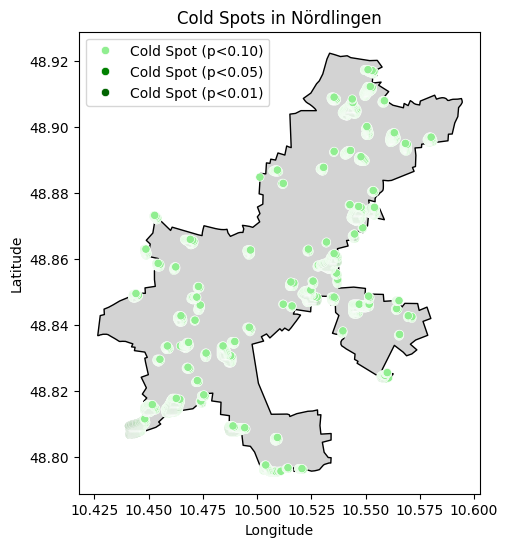

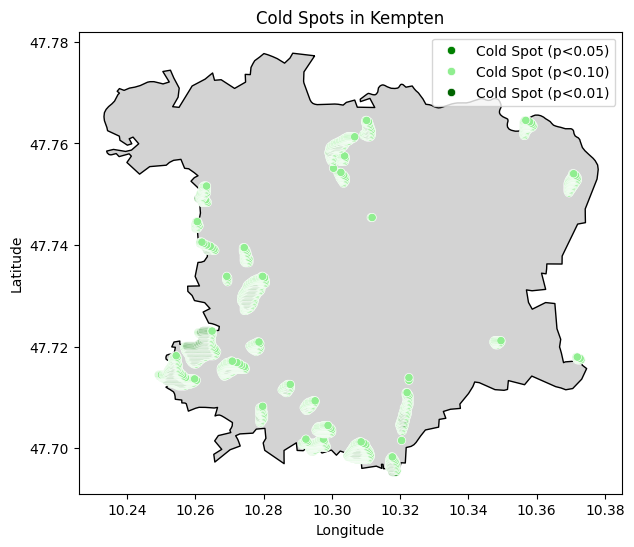

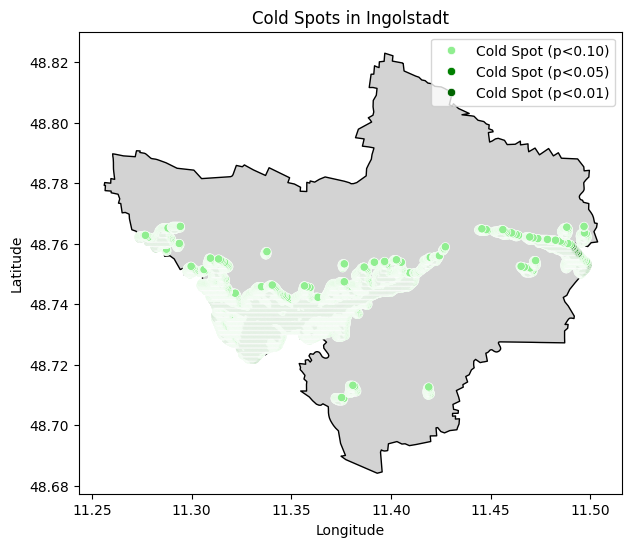

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load administrative boundaries (replace with your file paths)
boundary_noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Gerenze_shp.shp")
boundary_kempten = gpd.read_file("/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp")
boundary_ingolstadt = gpd.read_file("/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp")

# 2. Ensure CRS consistency
desired_crs = "EPSG:4326"  # Example: WGS 84

# Set the CRS for the GeoDataFrames before transforming
gdf_noerdlingen.crs = 'EPSG:4326'
gdf_kempten.crs = 'EPSG:4326'
gdf_ingolstadt.crs = 'EPSG:4326'


boundary_noerdlingen = boundary_noerdlingen.to_crs(desired_crs)
boundary_kempten = boundary_kempten.to_crs(desired_crs)
boundary_ingolstadt = boundary_ingolstadt.to_crs(desired_crs)
gdf_noerdlingen = gdf_noerdlingen.to_crs(desired_crs)
gdf_kempten = gdf_kempten.to_crs(desired_crs)
gdf_ingolstadt = gdf_ingolstadt.to_crs(desired_crs)


def plot_coldspots_with_boundaries(gdf, boundary_gdf, city_name):
    # Filter for Cold Spots
    coldspots_gdf = gdf[gdf["Spot Type"].str.startswith("Cold Spot")]

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    boundary_gdf.plot(ax=ax, color="lightgray", edgecolor="black")  # Plot boundary
    sns.scatterplot(
        x=coldspots_gdf.geometry.x,
        y=coldspots_gdf.geometry.y,
        hue=coldspots_gdf["Spot Type"],
        palette={
            "Cold Spot (p<0.01)": "darkgreen",
            "Cold Spot (p<0.05)": "green",
            "Cold Spot (p<0.10)": "lightgreen",
        },
        ax=ax,  # Use the same axes for both plots
    )
    plt.title(f"Cold Spots in {city_name}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()

# Plot for each city
plot_coldspots_with_boundaries(gdf_noerdlingen, boundary_noerdlingen, "Nördlingen")
plot_coldspots_with_boundaries(gdf_kempten, boundary_kempten, "Kempten")
plot_coldspots_with_boundaries(gdf_ingolstadt, boundary_ingolstadt, "Ingolstadt")

Datenpunkte können als Cold Spots verwendet werden und mit LST Karten verglichen werden oder Spalte mit "Cold Spots" in LST Datei hinzugefügt werden für Erreichbarkeitsanalysen

prüfen, wie sich räumliche Ausdehnung der Cold Spots (also addierte Fläche aller Cold Spots), sowie die Anzahl der Cold Spots ändert, wenn man jeweils nur die Spots mit einem z Wert von < -2.58, von < -1.96 und von < -1.65 mit einbezieht

In [18]:
import geopandas as gpd

def analyze_cold_spots(gdf):
    thresholds = [-2.58, -1.96, -1.65]
    results = []
    for threshold in thresholds:
        cold_spots = gdf[gdf["Gi*"] < threshold]

         # Geometriespalte überprüfen und ggf. erstellen
        if 'geometry' not in cold_spots.columns or cold_spots.geometry.is_empty.any():
            cold_spots['geometry'] = gpd.points_from_xy(cold_spots.longitude, cold_spots.latitude)

        # CRS überprüfen und ggf. setzen
        if cold_spots.crs is None:
            cold_spots.crs = 'epsg:4326'

        # Geometrien in UTM projizieren
        cold_spots = cold_spots.to_crs("EPSG:32632")  # UTM Zone 32N
        num_cold_spots = len(cold_spots)
        total_area = cold_spots.geometry.area.sum()  # in Quadratmetern
        results.append([threshold, num_cold_spots, total_area])

    return pd.DataFrame(results, columns=["Threshold", "Num_Cold_Spots", "Total_Area"])

# Beispielaufruf für Nördlingen
results_noerdlingen = analyze_cold_spots(gdf_noerdlingen)
print("Ergebnisse für Nördlingen:")
print(results_noerdlingen)

# Beispielaufruf für Kempten
results_kempten = analyze_cold_spots(gdf_kempten)
print("\nErgebnisse für Kempten:")
print(results_kempten)

# Beispielaufruf für Ingolstadt
results_ingolstadt = analyze_cold_spots(gdf_ingolstadt)
print("\nErgebnisse für Ingolstadt:")
print(results_ingolstadt)

Ergebnisse für Nördlingen:
   Threshold  Num_Cold_Spots  Total_Area
0      -2.58             186         0.0
1      -1.96            1386         0.0
2      -1.65            3967         0.0

Ergebnisse für Kempten:
   Threshold  Num_Cold_Spots  Total_Area
0      -2.58               1         0.0
1      -1.96             889         0.0
2      -1.65            2907         0.0

Ergebnisse für Ingolstadt:
   Threshold  Num_Cold_Spots  Total_Area
0      -2.58             594         0.0
1      -1.96           10696         0.0
2      -1.65           22537         0.0


kempten nur einer bei -2.58, weil Stadt allgemein eher kühl? Also wenn Mittelwert allgemein kühler, dann sind auch nicht so signifikante Abweichungen davon erkennbar, obwohl Temperaturen sehr kühl sind => nicht offensichtliche Cold Spots, weil es nicht wirklich Hot Spots gibt!!

Fläche zeigt 0 an, weil Cold Spots als Punktgeometrien vorliegen, nicht als Polygone => in Polygone umwandeln: konvexe Hülle um Cold Spots erstellen

In [42]:
import geopandas as gpd

def calculate_cold_spot_area(gdf, threshold): # threshold als Argument hinzugefügt
    cold_spots = gdf[gdf["Gi*"] < threshold]  # Filterung mit threshold

    # Geometriespalte überprüfen und ggf. erstellen
    if 'geometry' not in cold_spots.columns or cold_spots.geometry.is_empty.any():
        cold_spots['geometry'] = gpd.points_from_xy(cold_spots.longitude, cold_spots.latitude)

    # CRS überprüfen und ggf. setzen
    if cold_spots.crs is None:
        cold_spots.crs = 'epsg:4326'

    # Geometrien in UTM projizieren
    cold_spots = cold_spots.to_crs("EPSG:32632")  # UTM Zone 32N

    # Konvexe Hülle der Cold Spots erstellen (oder Puffer verwenden)
    cold_spots_polygon = cold_spots.unary_union.convex_hull # or cold_spots_polygon = cold_spots.buffer(10)

    total_area_km2 = cold_spots_polygon.area / 1000000 # Quadratkilometer
    return total_area_km2

# Berechnung und Ausgabe der Gesamtfläche für jede Stadt und jeden Threshold
cities = {
    "Nördlingen": gdf_noerdlingen,
    "Kempten": gdf_kempten,
    "Ingolstadt": gdf_ingolstadt
}

thresholds = [-2.58, -1.96, -1.65] # Thresholds definiert

for city_name, gdf in cities.items():
    for threshold in thresholds: # Schleife über Thresholds hinzugefügt
        total_area = calculate_cold_spot_area(gdf, threshold) # threshold an Funktion übergeben
        print(f"Gesamtfläche der Cold Spots für {city_name} (Gi* < {threshold:.2f}): {total_area:.2f} Quadratkilometer")

Gesamtfläche der Cold Spots für Nördlingen (Gi* < -2.58): 0.49 Quadratkilometer
Gesamtfläche der Cold Spots für Nördlingen (Gi* < -1.96): 69.63 Quadratkilometer
Gesamtfläche der Cold Spots für Nördlingen (Gi* < -1.65): 97.08 Quadratkilometer
Gesamtfläche der Cold Spots für Kempten (Gi* < -2.58): 0.00 Quadratkilometer
Gesamtfläche der Cold Spots für Kempten (Gi* < -1.96): 27.14 Quadratkilometer
Gesamtfläche der Cold Spots für Kempten (Gi* < -1.65): 54.95 Quadratkilometer
Gesamtfläche der Cold Spots für Ingolstadt (Gi* < -2.58): 1.70 Quadratkilometer
Gesamtfläche der Cold Spots für Ingolstadt (Gi* < -1.96): 64.46 Quadratkilometer
Gesamtfläche der Cold Spots für Ingolstadt (Gi* < -1.65): 73.55 Quadratkilometer


<ipython-input-42-953da9e6aafc>:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cold_spots_polygon = cold_spots.unary_union.convex_hull # or cold_spots_polygon = cold_spots.buffer(10)
<ipython-input-42-953da9e6aafc>:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cold_spots_polygon = cold_spots.unary_union.convex_hull # or cold_spots_polygon = cold_spots.buffer(10)
<ipython-input-42-953da9e6aafc>:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cold_spots_polygon = cold_spots.unary_union.convex_hull # or cold_spots_polygon = cold_spots.buffer(10)
<ipython-input-42-953da9e6aafc>:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cold_spots_polygon = cold_spots.unary_union.convex_hull # or cold_spots_polygon = cold_spots.buffer(10)
<ipython-input-42-953da9e6aa

In [43]:
# Berechnung und Ausgabe der Gesamtfläche für jede Stadt und jeden Threshold
cities = {
    "Nördlingen": gdf_noerdlingen,
    "Kempten": gdf_kempten,
    "Ingolstadt": gdf_ingolstadt
}

thresholds = [-2.58, -1.96, -1.65]

for city_name, gdf in cities.items():
    area_258 = calculate_cold_spot_area(gdf, thresholds[0]) # Fläche für -2.58
    area_196 = calculate_cold_spot_area(gdf, thresholds[1]) # Fläche für -1.96
    area_165 = calculate_cold_spot_area(gdf, thresholds[2]) # Fläche für -1.65

    # Prozentuale Veränderung berechnen, prüfe ob area_258 0 ist
    if area_258 != 0:  # Überprüfen, ob area_258 ungleich 0 ist
        change_196 = ((area_196 - area_258) / area_258) * 100
        change_165 = ((area_165 - area_258) / area_258) * 100
    else:
        change_196 = float('inf') # oder einen anderen Wert, der für dich Sinn macht (z.B. np.nan)
        change_165 = float('inf') # oder einen anderen Wert, der für dich Sinn macht (z.B. np.nan)

    print(f"Für {city_name}:")
    print(f"  Veränderung der Fläche bei Gi* < -1.96: {change_196:.2f}%")
    print(f"  Veränderung der Fläche bei Gi* < -1.65: {change_165:.2f}%")


Für Nördlingen:
  Veränderung der Fläche bei Gi* < -1.96: 14211.77%
  Veränderung der Fläche bei Gi* < -1.65: 19854.53%
Für Kempten:
  Veränderung der Fläche bei Gi* < -1.96: inf%
  Veränderung der Fläche bei Gi* < -1.65: inf%
Für Ingolstadt:
  Veränderung der Fläche bei Gi* < -1.96: 3682.77%
  Veränderung der Fläche bei Gi* < -1.65: 4216.36%


<ipython-input-42-953da9e6aafc>:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cold_spots_polygon = cold_spots.unary_union.convex_hull # or cold_spots_polygon = cold_spots.buffer(10)
<ipython-input-42-953da9e6aafc>:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cold_spots_polygon = cold_spots.unary_union.convex_hull # or cold_spots_polygon = cold_spots.buffer(10)
<ipython-input-42-953da9e6aafc>:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cold_spots_polygon = cold_spots.unary_union.convex_hull # or cold_spots_polygon = cold_spots.buffer(10)
<ipython-input-42-953da9e6aafc>:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cold_spots_polygon = cold_spots.unary_union.convex_hull # or cold_spots_polygon = cold_spots.buffer(10)
<ipython-input-42-953da9e6aa

da es für Kempten nur einen Cold Spot mit z-Wert kleiner als -2.58 gibt und Fläche dementsprechend sehr gering ist, zeigt auch die prozentuelle Veränderung unendlich an.


berechnen, um wieviel Grad kälter der LST-Mittelwert der verschiedenen Cold-spot-gruppen (verschiedene z-Werte) im Vergleich zum Gesamtmittelwert der Stadt und im Vergleich zu den verschiedenen Hot-Spot-Gruppen ist

In [36]:
import geopandas as gpd
import numpy as np

def analyze_lst_difference(gdf, thresholds):
    results = {}
    overall_mean = gdf["LST_Celsius"].mean() # Gesamtmittelwert
    results["Gesamtmittelwert"] = overall_mean # Gesamtmittelwert speichern

    for threshold in thresholds: # Schleife über Thresholds für Cold Spots
        group_name = f"Cold Spot (Gi* < {threshold:.2f})"
        group_mean = gdf[gdf["Gi*"] < threshold]["LST_Celsius"].mean()
        results[group_name] = group_mean
        diff_to_overall = group_mean - overall_mean # Differenz zu Gesamtmittelwert
        print(f"{group_name}: {group_mean:.2f} °C (Differenz zum Gesamtmittelwert: {diff_to_overall:.2f} °C)")


    for threshold in thresholds: # Schleife über Thresholds für Hot Spots
        group_name = f"Hot Spot (Gi* > {threshold:.2f})"
        group_mean = gdf[gdf["Gi*"] > threshold]["LST_Celsius"].mean()
        results[group_name] = group_mean
        diff_to_overall = group_mean - overall_mean # Differenz zu Gesamtmittelwert
        print(f"{group_name}: {group_mean:.2f} °C (Differenz zum Gesamtmittelwert: {diff_to_overall:.2f} °C)")


    # Differenz zwischen Cold und Hot Spots berechnen
    for cold_threshold in thresholds:
        for hot_threshold in thresholds:
            cold_group_name = f"Cold Spot (Gi* < {cold_threshold:.2f})"
            hot_group_name = f"Hot Spot (Gi* > {hot_threshold:.2f})"
            diff_cold_hot = results[cold_group_name] - results[hot_group_name]
            print(f"Differenz zwischen {cold_group_name} und {hot_group_name}: {diff_cold_hot:.2f} °C")

    return results

# Thresholds definieren
thresholds = [1.65, 1.96, 2.58]  # Die Thresholds für die Hot/Cold Spots

# Analyse für jede Stadt durchführen
cities = {
    "Nördlingen": gdf_noerdlingen,
    "Kempten": gdf_kempten,
    "Ingolstadt": gdf_ingolstadt
}

for city_name, gdf in cities.items():
    print(f"\nAnalyse für {city_name}:")
    results = analyze_lst_difference(gdf, thresholds)


Analyse für Nördlingen:
Cold Spot (Gi* < 1.65): 36.01 °C (Differenz zum Gesamtmittelwert: -0.29 °C)
Cold Spot (Gi* < 1.96): 36.12 °C (Differenz zum Gesamtmittelwert: -0.18 °C)
Cold Spot (Gi* < 2.58): 36.23 °C (Differenz zum Gesamtmittelwert: -0.07 °C)
Hot Spot (Gi* > 1.65): 41.86 °C (Differenz zum Gesamtmittelwert: 5.56 °C)
Hot Spot (Gi* > 1.96): 42.67 °C (Differenz zum Gesamtmittelwert: 6.37 °C)
Hot Spot (Gi* > 2.58): 44.37 °C (Differenz zum Gesamtmittelwert: 8.07 °C)
Differenz zwischen Cold Spot (Gi* < 1.65) und Hot Spot (Gi* > 1.65): -5.84 °C
Differenz zwischen Cold Spot (Gi* < 1.65) und Hot Spot (Gi* > 1.96): -6.65 °C
Differenz zwischen Cold Spot (Gi* < 1.65) und Hot Spot (Gi* > 2.58): -8.35 °C
Differenz zwischen Cold Spot (Gi* < 1.96) und Hot Spot (Gi* > 1.65): -5.73 °C
Differenz zwischen Cold Spot (Gi* < 1.96) und Hot Spot (Gi* > 1.96): -6.54 °C
Differenz zwischen Cold Spot (Gi* < 1.96) und Hot Spot (Gi* > 2.58): -8.24 °C
Differenz zwischen Cold Spot (Gi* < 2.58) und Hot Spot (G

Cold Spots allgemein nur sehr geringen Unterschied zum Gesamtmittelwert => kann an Berechnugnsart liegen: Getis-Methode **vergleicht mit unmittelbarem räumlichen Umfeld, nicht mit Gesamtmittelwert  **

verwunderlich: Cold Spots mit z-Wert -1.65 haben größten Abstand zum Mittelwert, obwohl zu erwarten wäre, dass cold spots mit strengerem schwellenwert kälter sind

aber dann: Threshold von -1.65 wählen! => mehr und allgemein kühlere Cold Spots, allerdings: p-Wert davon höher

In [44]:
import pandas as pd

def analyze_spot_stats(gdf, thresholds):
    results = {}

    # Cold Spots
    for threshold in thresholds:
        group_name = f"Cold Spot (Gi* < {threshold:.2f})"
        group = gdf[gdf["Gi*"] < threshold]["LST_Celsius"]
        results[group_name] = {
            "min": group.min(),
            "max": group.max(),
            "mean": group.mean()
        }

    # Hot Spots
    for threshold in thresholds:
        group_name = f"Hot Spot (Gi* > {threshold:.2f})"
        group = gdf[gdf["Gi*"] > threshold]["LST_Celsius"]
        results[group_name] = {
            "min": group.min(),
            "max": group.max(),
            "mean": group.mean()
        }

    return results

# Thresholds definieren
thresholds = [1.65, 1.96, 2.58]

# Analyse für jede Stadt durchführen
cities = {
    "Nördlingen": gdf_noerdlingen,
    "Kempten": gdf_kempten,
    "Ingolstadt": gdf_ingolstadt
}

for city_name, gdf in cities.items():
    print(f"\nAnalyse für {city_name}:")
    results = analyze_spot_stats(gdf, thresholds)
    for group_name, stats in results.items():
        print(f"{group_name}:")
        print(f"  Min: {stats['min']:.2f} °C")
        print(f"  Max: {stats['max']:.2f} °C")
        print(f"  Mean: {stats['mean']:.2f} °C")


Analyse für Nördlingen:
Cold Spot (Gi* < 1.65):
  Min: 28.59 °C
  Max: 42.01 °C
  Mean: 36.01 °C
Cold Spot (Gi* < 1.96):
  Min: 28.59 °C
  Max: 42.44 °C
  Mean: 36.12 °C
Cold Spot (Gi* < 2.58):
  Min: 28.59 °C
  Max: 44.62 °C
  Mean: 36.23 °C
Hot Spot (Gi* > 1.65):
  Min: 39.37 °C
  Max: 49.76 °C
  Mean: 41.86 °C
Hot Spot (Gi* > 1.96):
  Min: 39.60 °C
  Max: 49.76 °C
  Mean: 42.67 °C
Hot Spot (Gi* > 2.58):
  Min: 41.66 °C
  Max: 49.76 °C
  Mean: 44.37 °C

Analyse für Kempten:
Cold Spot (Gi* < 1.65):
  Min: 22.30 °C
  Max: 38.19 °C
  Mean: 31.58 °C
Cold Spot (Gi* < 1.96):
  Min: 22.30 °C
  Max: 38.98 °C
  Mean: 31.76 °C
Cold Spot (Gi* < 2.58):
  Min: 22.30 °C
  Max: 41.90 °C
  Mean: 31.98 °C
Hot Spot (Gi* > 1.65):
  Min: 35.49 °C
  Max: 44.14 °C
  Mean: 38.48 °C
Hot Spot (Gi* > 1.96):
  Min: 36.34 °C
  Max: 44.14 °C
  Mean: 39.21 °C
Hot Spot (Gi* > 2.58):
  Min: 38.78 °C
  Max: 44.14 °C
  Mean: 40.68 °C

Analyse für Ingolstadt:
Cold Spot (Gi* < 1.65):
  Min: 23.15 °C
  Max: 45.12 °C
  

sinnvoll? Minimum bei Cold Spots in allen Gruppen gleich...